# Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import spacy
import joblib
import re

In [23]:
# Function to load data from a CSV file
def load_data(path = '/content/reviews.csv'):
  df=pd.read_csv(path) # Reads the CSV file into a DataFrame
  print(f"loaded {df.shape[0]} rows and {df.shape[1]} columns.") # Prints number of rows and columns
  return df

In [24]:
# Loading the dataset
df = load_data('/content/reviews.csv')

loaded 18442 rows and 9 columns.


# **EDA**

In [25]:
df.info()# Displays summary of the DataFrame including data types and non-null values
df.describe()  # Displays basic statistics of the numerical columns
df.isnull().sum() # Checks for any missing values in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


,0
Clothing ID,0
Age,0
Title,0
Review Text,0
Positive Feedback Count,0
Division Name,0
Department Name,0
Class Name,0
Recommended IND,0


<Axes: xlabel='Recommended IND', ylabel='count'>

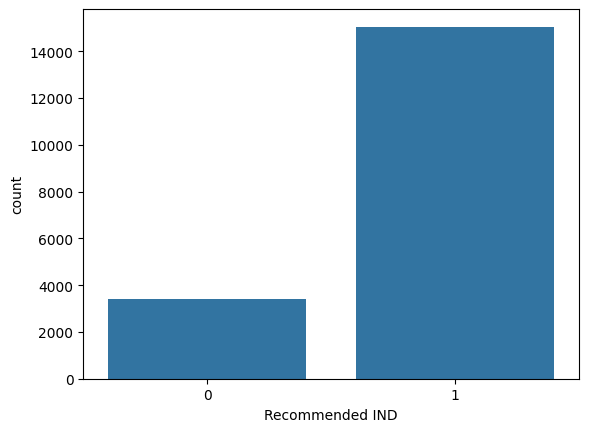

In [26]:
# Visualize distribution of the 'Recommended IND' column (target variable)
sns.countplot(x='Recommended IND', data=df)

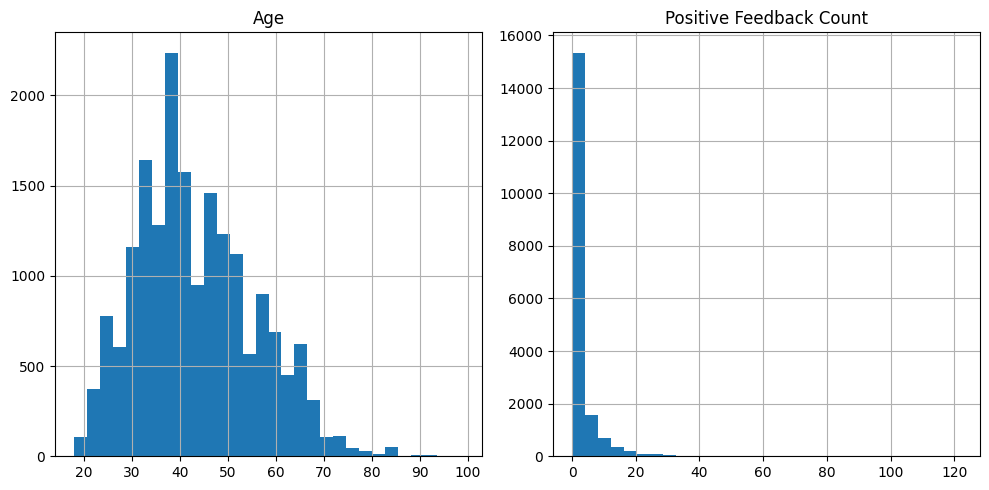

In [27]:
# Visualize numerical features (Age, Positive Feedback Count)
numeric_features = ['Age', 'Positive Feedback Count']
df[numeric_features].hist(bins=30, figsize=(10, 5)) # Histogram for numerical features
plt.tight_layout() # Adjusts subplots for better layout
plt.show()

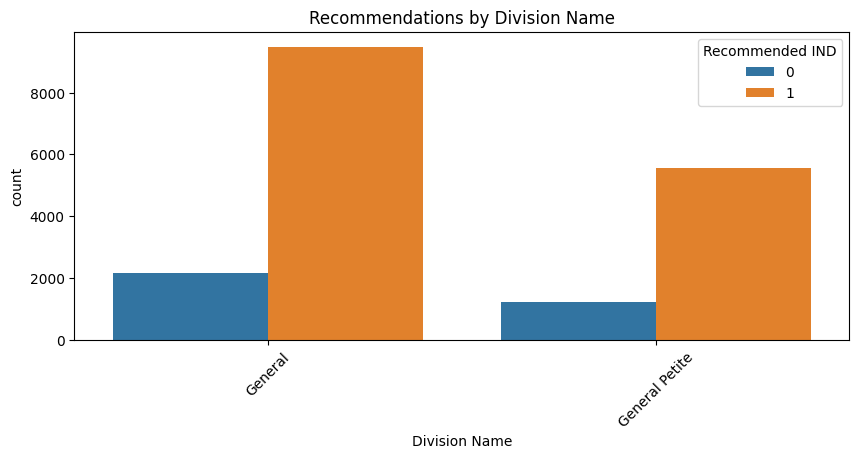

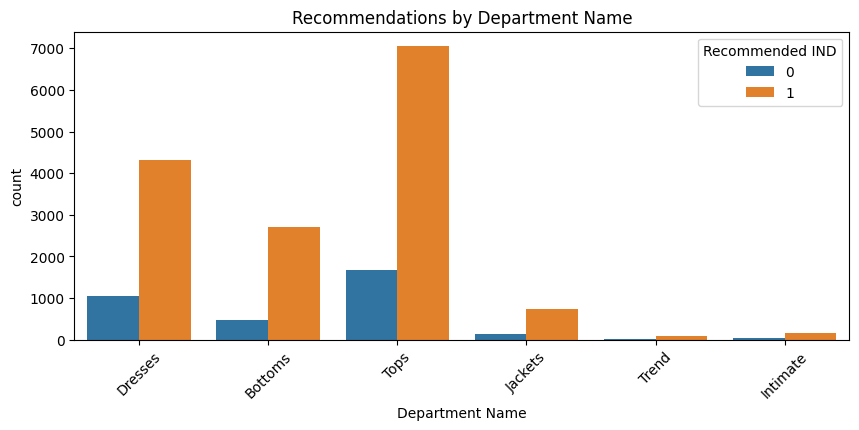

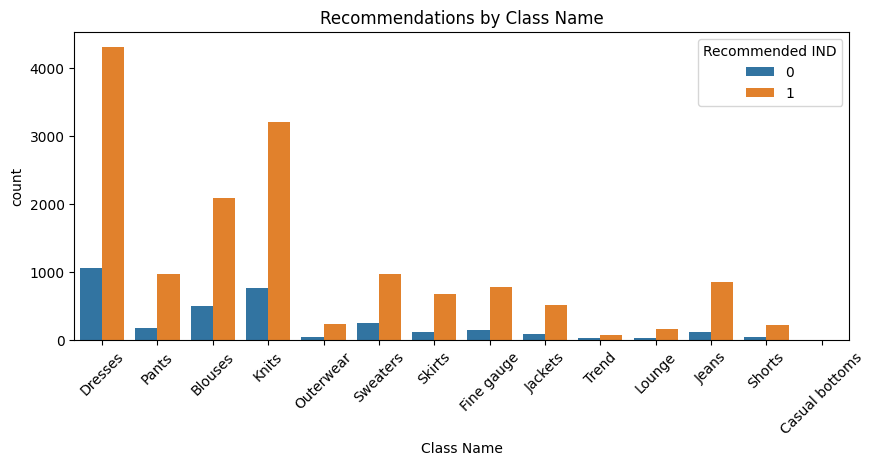

In [28]:
# Visualize categorical features with respect to the 'Recommended IND' (target)
categorical_features = ['Division Name', 'Department Name', 'Class Name']
for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=feature, hue='Recommended IND')
    plt.xticks(rotation=45)
    plt.title(f'Recommendations by {feature}')
    plt.show()

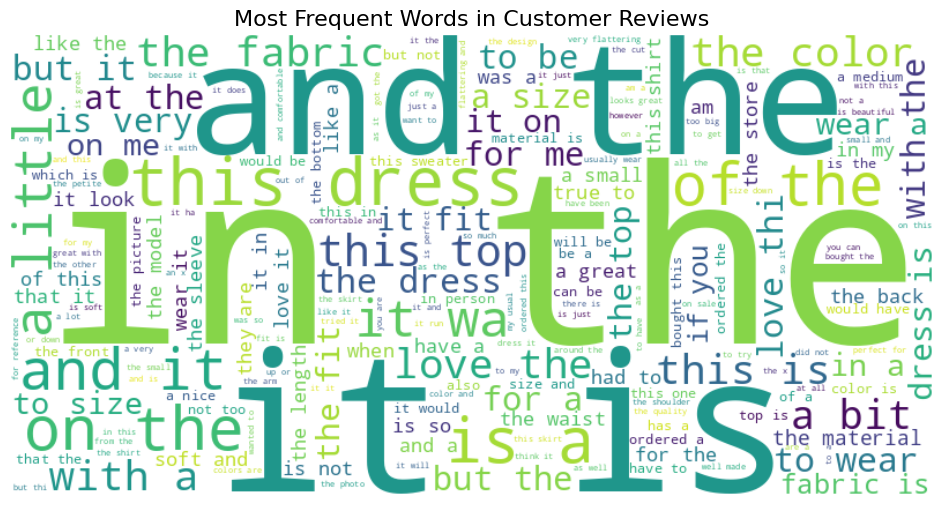

In [29]:
# Combine all reviews into a single string for word cloud generation
all_reviews = ' '.join(df['Review Text'].dropna().astype(str))
# Create a word cloud to visualize the most frequent words in reviews
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords='english').generate(all_reviews)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')  # Displays word cloud
plt.axis('off') # Turns off axis for clean visualization
plt.title('Most Frequent Words in Customer Reviews', fontsize=16)
plt.show()

In [30]:
# Load the spaCy model for text preprocessing
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
# Function to preprocess text data (lowercase, lemmatization, remove stop words)
def preprocess_text(text):
  if pd.isnull(text):
    return ""
  doc = nlp(text.lower())  # Lowercase the text and process using spaCy
  tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
  return " ".join(tokens)

In [31]:
# Function to prepare the data (preprocess text, split into training and test sets)
def prepare_data(df):
    df['Title'] = df['Title'].progress_apply(preprocess_text)
    df['Review Text'] = df['Review Text'].progress_apply(preprocess_text)

    X = df.drop('Recommended IND', axis=1) # Features (all columns except target)
    y = df['Recommended IND'] # Target variable
    return train_test_split(X, y, test_size=0.1, random_state=27, shuffle=True) # Split the data

In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = prepare_data(df)

# **Building the Pipeline**

In [32]:
# Function to build the preprocessing pipeline
def build_pipeline(numeric_features, categorical_features):
    # Define transformers for numerical, categorical, and text data
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])  # Scale numeric features
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])  # One-hot encode categorical features
    title_transformer = Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=100))])  # TF-IDF for 'Title'
    review_transformer = Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=500))])  # TF-IDF for 'Review Text'

    # Combine all transformers into one preprocessor
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('title', title_transformer, 'Title'),
        ('review', review_transformer, 'Review Text')
    ])

    # Create the complete pipeline with classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))  # RandomForest model
    ])
    return pipeline


In [33]:
# Build the pipeline
pipeline = build_pipeline(numeric_features, categorical_features)

In [34]:
# Function to train the baseline model
def train_baseline_model(pipeline, X_train, y_train):
    print("🔹 Training baseline model...")
    pipeline.fit(X_train, y_train)  # Fit the pipeline on training data
    return pipeline

In [36]:
# Train the baseline model
baseline_model = train_baseline_model(pipeline, X_train, y_train)

🔹 Training baseline model...


In [37]:
# Function to evaluate the model's performance
def evaluate_model(model, X_test, y_test, title="Model Evaluation"):
    print(f"\n📊 {title}")
    y_pred = model.predict(X_test)  # Make predictions on the test set
    print("Classification Report:\n", classification_report(y_test, y_pred))  # Print classification report
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))  # Print confusion matrix

In [38]:
# Evaluate the baseline model
evaluate_model(baseline_model, X_test, y_test, title="Baseline Model")


📊 Baseline Model
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.37      0.49       327
           1       0.88      0.97      0.92      1518

    accuracy                           0.86      1845
   macro avg       0.81      0.67      0.71      1845
weighted avg       0.85      0.86      0.85      1845

Confusion Matrix:
 [[ 121  206]
 [  44 1474]]


# **Model Evaluation Analysis:**
 - The model works well for positive recommendations, but struggles with negative ones.
- Overall accuracy is good (86%), but it often misclassifies negative reviews as positive.
 - The dataset has more positive reviews, which affects the results.
 - Improving the model's ability to handle negative reviews is the next step.


In [39]:
# Function to fine-tune the model using GridSearchCV
def tune_model(pipeline, X_train, y_train):
    print("🔸 Fine-tuning with GridSearchCV...")
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train) # Handle class imbalance
    weight_dict = {0: class_weights[0], 1: class_weights[1]} # Assign weights to classes

    pipeline.set_params(classifier__class_weight=weight_dict) # Assign weights to classes
    # Define parameter grid for GridSearchCV
    param_grid = {
        'classifier__n_estimators': [100, 200],  # Number of trees in RandomForest
        'classifier__max_depth': [None, 10, 20]  # Maximum depth of trees
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)  # Perform GridSearchCV
    grid_search.fit(X_train, y_train)  # Fit GridSearchCV

    print("✅ Best Parameters:", grid_search.best_params_) # Display the best parameters
    return grid_search

In [40]:
# Fine-tune the model
tuned_model = tune_model(pipeline, X_train, y_train)
evaluate_model(tuned_model, X_test, y_test, title="Fine-Tuned Model")

🔸 Fine-tuning with GridSearchCV...
✅ Best Parameters: {'classifier__max_depth': 20, 'classifier__n_estimators': 200}

📊 Fine-Tuned Model
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.73      0.64       327
           1       0.94      0.88      0.91      1518

    accuracy                           0.86      1845
   macro avg       0.76      0.81      0.78      1845
weighted avg       0.87      0.86      0.86      1845

Confusion Matrix:
 [[ 239   88]
 [ 177 1341]]


# **Fine-Tuned Model Evaluation Analysis:**
 - The fine-tuned model shows better balance between precision and recall for both classes.
- The accuracy remains the same at 86%, with an improvement in identifying negative reviews.
- The model is now better at predicting negative reviews (class 0), with a recall of 0.73, compared to the baseline model's 0.37.
 - However, the positive reviews (class 1) still have a high precision and recall, showing the model's strength in handling them.


In [42]:
# Function to save the trained model
def save_model(model, filename='model_pipeline.pkl'):
    joblib.dump(model, filename) # Save the model to a file
    print(f"💾 Model saved to {filename}")

In [43]:
# Save the fine-tuned model
save_model(tuned_model, filename='best_model_pipeline.pkl')

💾 Model saved to best_model_pipeline.pkl
